In [1]:
import pandas as pd

# df = pd.read_csv('./datasets/DisasterDeclarationSummariesPlusLocation_ArtificiallyClustered.csv')
# display(df)

df = pd.read_csv('../../Datasets/DisasterDataset_WithBetterNoDisasters.csv')
df = df.rename(columns={'X': 'longitude', 'Y': 'latitude'})
df = df.fillna(0)

display(df)
# print(min(df['disasterType_categoricalEncoding']))
# print(max(df['disasterType_categoricalEncoding']))

/var/folders/6k/yg9y73qs2hz37v5r2l39pt0m0000gn/T/ipykernel_5777/1657504827.py:6: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../Datasets/DisasterDataset_WithBetterNoDisasters.csv')


,incidentBeginDate,incidentEndDate,longitude,latitude,declarationTitle,incidentId,incidentId_categoricalEncoding,commonIncidentIdGroupSize,timeOfStartInDays,timeOfEndInDays,incidentDurationInDays,disasterType_storm,disasterType_flood,disasterType_rain,disasterType_ice,disasterType_snow,disasterType_blizzard,disasterType_hurricane,disasterType_categoricalEncoding,disasterOccurred
0,1953-05-15 00:00:00+00:00,1953-05-15T00:00:00.000Z,-97.494516,30.350192,TORNADO & HEAVY RAINFALL,53003.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,1953-05-29 00:00:00+00:00,1953-05-29T00:00:00.000Z,-97.540981,35.470449,FLOOD,53005.0,1.0,1.0,14.000000,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,1953-06-06 00:00:00+00:00,1953-06-06T00:00:00.000Z,-108.769245,45.670160,FLOODS,53006.0,2.0,1.0,22.000000,22.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,1953-06-11 00:00:00+00:00,1953-06-11T00:00:00.000Z,-97.540981,35.470449,FLOOD,53008.0,3.0,1.0,27.000000,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,1953-06-19 00:00:00+00:00,1953-06-19T00:00:00.000Z,-97.494516,30.350192,FLOOD,53010.0,4.0,1.0,35.000000,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94087,0,0,-77.074982,32.361111,0,0.0,0.0,0.0,18903.323431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94088,0,0,-76.354076,44.038167,0,0.0,0.0,0.0,26098.218864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94089,0,0,-106.323460,48.189649,0,0.0,0.0,0.0,19950.660076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94090,0,0,-89.976937,30.656996,0,0.0,0.0,0.0,8291.371477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib  
import pdb

MODEL_PATH = "../../ui_component/saved_prediction_models/disaster_lstm.pth"
SCALER_PATH = "../../ui_component/saved_prediction_models/scaler.pkl"

# Load dataset (Ensure df is loaded before this)
# df = pd.read_csv("your_data.csv")  # Uncomment if loading from a file

# Define disaster type columns
# disaster_type_columns = [
#     "disasterType_storm", "disasterType_flood", "disasterType_rain",
#     "disasterType_ice", "disasterType_snow", "disasterType_blizzard",
#     "disasterType_hurricane"
# ]

# Normalize features
scaler = MinMaxScaler()
df[['latitude', 'longitude', 'timeOfStartInDays']] = scaler.fit_transform(df[['latitude', 'longitude', 'timeOfStartInDays']])
joblib.dump(scaler, SCALER_PATH)

# Define inputs (X) and outputs (y)
X = df[['latitude', 'longitude', 'timeOfStartInDays']].values  # Only time and location
y = df[['disasterOccurred']].values  # Disaster occurred + type

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM Model
class DisasterLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(DisasterLSTM, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)  # First layer to extract spatial features
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True, num_layers=3)
        self.fc2 = nn.Linear(64, output_size)  
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)  # Transform input before LSTM
        x = self.relu(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        _, (h_n, _) = self.lstm(x)
        x = self.fc2(h_n[-1]) 
        x = self.sigmoid(x)
        return x

# Initialize model
input_size = X_train.shape[1]  # 3 (time, lat, lon)
output_size = y_train.shape[1]  # 1 (disasterOccurred)
model = DisasterLSTM(input_size, output_size)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 550
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Compute test loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        # test_outputs = torch.where(test_outputs >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
        # print(test_outputs)
        test_loss = criterion(test_outputs, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Save trained model
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Plot training vs. testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(test_losses, label="Testing Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Testing Loss")
plt.legend()
plt.show()

# Load trained model (optional)
# model.load_state_dict(torch.load(MODEL_PATH))
# model.eval()




Epoch [0/550], Train Loss: 0.6947, Test Loss: 0.6931
Epoch [100/550], Train Loss: 0.4204, Test Loss: 0.4214


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, brier_score_loss, mean_squared_error,classification_report

# Get model predictions
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test)  # Get raw probabilities
    y_pred = (y_pred_probs > 0.5).int()  # Convert to 0 or 1

# Convert tensors to NumPy for sklearn
y_pred_np = y_pred.numpy()
y_test_np = y_test.numpy()

# Compute metrics for binary classification of disaster occurence
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')  # or 'weighted'
recall = recall_score(y_test_np, y_pred_np, average='macro')
f1 = f1_score(y_test_np, y_pred_np, average='macro')
roc_auc = roc_auc_score(y_test_np, y_pred_probs.numpy(), average='macro', multi_class='ovr')  # One-vs-Rest for multi-label
bce_loss = nn.BCELoss()(torch.tensor(y_pred_probs), torch.tensor(y_test_np)).item()
auc_roc = roc_auc_score(y_test_np, y_pred_probs)
pr_auc = average_precision_score(y_test_np, y_pred_probs)  # Precision-Recall AUC
brier = brier_score_loss(y_test_np, y_pred_probs)
mse = mean_squared_error(y_test_np, y_pred_probs)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")



Accuracy: 0.8457
Precision: 0.8507
Recall: 0.8460
F1 Score: 0.8453
AUC-ROC: 0.9172
BCE Loss: 0.3547
AUC-ROC: 0.9172
Precision-Recall AUC: 0.8955
Brier Score: 0.1123
MSE: 0.1123
R2: 0.3830


C:\Users\Gavin\AppData\Local\Temp\ipykernel_3212\600838556.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bce_loss = nn.BCELoss()(torch.tensor(y_pred_probs), torch.tensor(y_test_np)).item()


: 

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      9447
         1.0       0.81      0.91      0.85      9372

    accuracy                           0.85     18819
   macro avg       0.85      0.85      0.85     18819
weighted avg       0.85      0.85      0.85     18819



## Below is a graph of disasters that occured as well as no-disaster points


C:\Users\Gavin\AppData\Local\Temp\ipykernel_3212\3986849755.py:6: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Gavin\AppData\Local\Temp\ipykernel_3212\3986849755.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(disaster_columns)+1)


1084


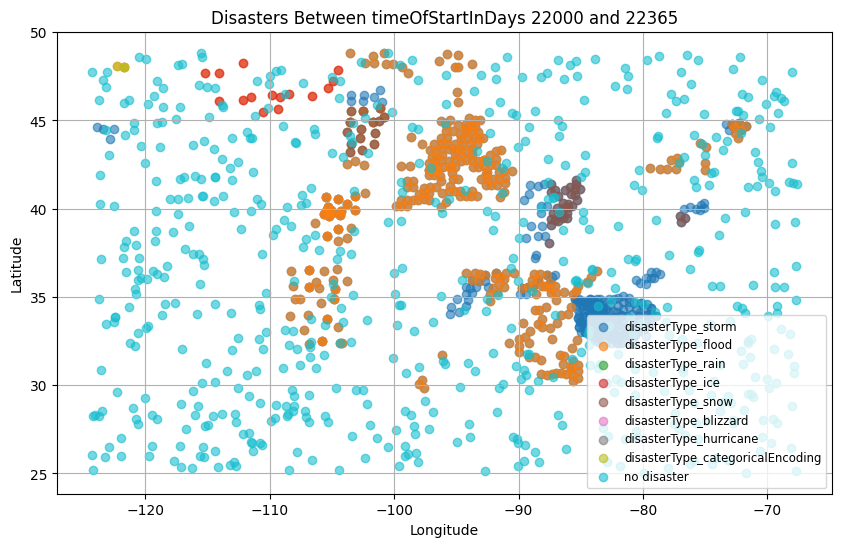

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "../../Datasets/DisasterDataset_WithBetterNoDisasters.csv"
df = pd.read_csv(file_path)

# Ensure 'timeOfStartInDays' column exists and filter the relevant time range
time_range = (22000,22365)
df_filtered = df[(df["timeOfStartInDays"] >= time_range[0]) & (df["timeOfStartInDays"] <= time_range[1])]
# Check available disaster type columns
disaster_columns = [col for col in df_filtered.columns if "disasterType_" in col]

# Assign a color for each disaster type
colors = plt.cm.get_cmap("tab10", len(disaster_columns)+1)
total = 0
# Plot the disasters on a scatter plot
plt.figure(figsize=(10, 6))
for i, disaster in enumerate(disaster_columns):
    subset = df_filtered[df_filtered[disaster] == 1]  # Get rows where this disaster type occurred
    # print(df_filtered[disaster])
    plt.scatter(subset["longitude"], subset["latitude"], label=disaster, alpha=0.6, color=colors(i))
    total += len(subset)
no_disasters = df_filtered[df_filtered['disasterOccurred'] == 0]
plt.scatter(no_disasters['longitude'], no_disasters['latitude'], label='no disaster', alpha=0.6, color=colors(len(disaster_columns)))
print(total)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Disasters Between timeOfStartInDays {time_range[0]} and {time_range[1]}")

plt.legend(loc="lower right", fontsize="small")
plt.grid(True)
plt.show()


## Below is a graph of the above datapoints plugged into the lstm model to predict where disasters would occur

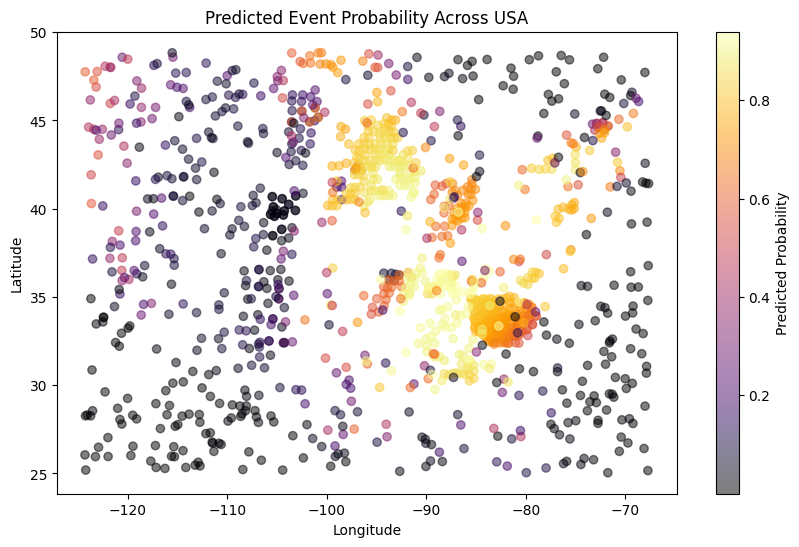

In [81]:
lats = df_filtered[['latitude']]
lons = df_filtered[['longitude']]
time_fixed = df_filtered[['timeOfStartInDays']]
data_points = np.column_stack((lats, lons, time_fixed))

# Normalize data (Ensure you use the same scaler as training)
data_points_scaled = scaler.fit_transform(data_points)  # Fit/transform for demo (use pre-trained scaler)

# Convert to Tensor for Model Input
input_tensor = torch.tensor(data_points_scaled, dtype=torch.float32) # Shape (batch, seq, features)

# Make Predictions
with torch.no_grad():
    predictions = model(input_tensor).numpy().flatten()  # Get probabilities

# Plot Results - Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(lons, lats, c=predictions, cmap="inferno", alpha=0.5)
plt.colorbar(label="Predicted Probability")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Event Probability Across USA")
plt.show()

# Convert to Heatmap Grid
num_grid = 100  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_grid)
lon_grid = np.linspace(lon_min, lon_max, num_grid)
grid_lats, grid_lons = np.meshgrid(lat_grid, lon_grid)



Extra code below that was not used

In [14]:
# Test for single point

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# loaded_model = DisasterLSTM(input_size=input_size, output_size=output_size)
# loaded_model.load_state_dict(torch.load(MODEL_PATH))
# loaded_model.eval()
# print("Model loaded successfully!")

disaster_types = ['storm', 'flood', 'rain', 'ice', 'snow', 'blizzard', 'hurricane']
one_hot_encoder = OneHotEncoder(categories=[disaster_types], handle_unknown="ignore")

new_data = {
    "latitude": 40.95,   # Example latitude
    "longitude": 60.76,  # Example longitude
    "timeInDays": 15000.782408825089,  # Future date
    # "disaster_type": "storm"  # Example disaster type
}

# scaler = joblib.load(SCALER_PATH)

scaled_input = scaler.transform([[new_data["latitude"], new_data["longitude"], new_data["timeInDays"]]])

print(scaled_input)
# disaster_encoded = one_hot_encoder.fit_transform([[new_data["disaster_type"]]]).toarray()
# final_input = np.hstack((scaled_input, disaster_encoded))

# Convert to PyTorch tensor
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

with torch.no_grad():
    prediction =model(input_tensor)
    # probability = prediction.item()
    print(prediction)
     
# print(f"Predicted probability of a disaster: {probability:.4f}")
# TODO: You were going to have chatgpt add some negative values in the dataset so that it can predict other than 1 probabilities.

[[ 6.58287639e-01  3.17629053e+00 -4.99921759e+03]]
tensor([[1.2330e-05]])


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load trained model (Assuming your EventProbabilityTransformer is already defined)
# model = EventProbabilityTransformer()
# model.load_state_dict(torch.load("model.pth"))  # Load your trained model
# model.eval()

# Define the bounding box for the USA
lat_min, lat_max = 24.5, 49.5
lon_min, lon_max = -125, -66.5

# Generate random latitude & longitude points across the USA
num_points = 5000  # More points = finer resolution
lats = np.random.uniform(lat_min, lat_max, num_points)
lons = np.random.uniform(lon_min, lon_max, num_points)
time_fixed = np.random.default_rng().integers(1000, 1365, size=(num_points, 1))  # Fix time for visualization

# Combine into dataset
data_points = np.column_stack((lats, lons, time_fixed))

# Normalize data (Ensure you use the same scaler as training)
# scaler = MinMaxScaler()
data_points_scaled = scaler.fit_transform(data_points)  # Fit/transform for demo (use pre-trained scaler)

# Convert to Tensor for Model Input
input_tensor = torch.tensor(data_points_scaled, dtype=torch.float32) # Shape (batch, seq, features)

# Make Predictions
with torch.no_grad():
    predictions = model(input_tensor).numpy().flatten()  # Get probabilities

# Plot Results - Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(lons, lats, c=predictions, cmap="inferno", alpha=0.5)
plt.colorbar(label="Predicted Probability")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predicted Event Probability Across USA")
plt.show()

# Convert to Heatmap Grid
num_grid = 100  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_grid)
lon_grid = np.linspace(lon_min, lon_max, num_grid)
grid_lats, grid_lons = np.meshgrid(lat_grid, lon_grid)

# Interpolate predictions onto the grid
from scipy.interpolate import griddata
grid_probs = griddata((lats, lons), predictions, (grid_lats, grid_lons), method="linear")

# Plot Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(grid_probs, xticklabels=10, yticklabels=10, cmap="inferno", alpha=0.8)
plt.title(f"Predicted Disaster Probability Heatmap (Day {time_fixed[0]})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
